In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
import torch
import numpy as np
import utils
import matplotlib.pyplot as plt
from dataset import DataSet
import pandas as pd
import glob
%load_ext autoreload
np.random.seed(2) 
torch.manual_seed(2)

In [48]:
lz = utils.get_data('../../datasets/ZTF_3C273', min_length=10, keep_missing=False)

found 2 for band='r'
found 1 for band='i'
found 2 for band='g'
max time:  1685.25
created union_tp attribute of length 3500
dataset created, lcs.dataset.shape=(1, 3, 686, 3)
train size: 0, valid size: 0, test size: 1


In [50]:
len(lz.dataset[0,1,:,1].nonzero()[0])

29

In [82]:
%autoreload

In [12]:
gri_scratch = '../../datasets/ZTF_MCG+08-11-011-1.0132036209106445.h5'

In [13]:
device = 'cpu'
# lcs = utils.get_data('../../datasets/ZTF_rm_segs/Mrk817/X/ZTF_epoch2_', test_split=0.2,shuffle=False, num_resamples=12, min_length=10,sep=' ',start_col=0,keep_missing=False)
#lcs = utils.get_data('../../datasets/ZTF_rm_segs/Mrk817/X/ZTF_epoch0_', test_split=0.2,shuffle=False, num_resamples=12, min_length=10,sep=' ',start_col=0,keep_missing=False)
lcs = utils.get_data('../../datasets/ZTF_MCG+08-11-011',test_split=0.2, shuffle=False, num_resamples=12, min_length=0, keep_missing=True)
net,optimizer,scheduler,lrs, args, epoch, losses = utils.load_checkpoint(gri_scratch, lcs.data_obj, device=device)
qzs,disc_path = utils.encode(lcs.data_obj['train_loader'], net, device=device)
n_samples = 10
zs = (np.random.randn(n_samples, qzs.shape[0], qzs.shape[2],qzs.shape[3]) * qzs[:,1,:,:] + qzs[:,0,:,:])
# choose target time points
target_tp = np.arange(0,np.max(lcs.dataset[0,0,:,0]),step=0.5, dtype=np.float32)
# format it... want (num exs x num bands x num tps)
#target_tp = lcs.dataset[:,0,:,0].flatten()
target_tp = target_tp[np.newaxis].repeat(len(lcs.bands),axis=0)[np.newaxis].repeat(lcs.dataset.shape[0],axis=0)
interps = np.array([utils.decode(net,z[:10],disc_path[:10],target_tp[:10],device=device) for z in zs])
t = interps[0,:,:,:,0]
y_avg = interps[:,:,:,:,1].mean(0)
yerr_avg = interps[:,:,:,:,2].mean(0)
intps = np.concatenate((t[np.newaxis],y_avg[np.newaxis],yerr_avg[np.newaxis]),axis=0).transpose(1,2,3,0)


found 1 for band='r'
found 1 for band='i'
found 1 for band='g'
max time:  1480.9922
created union_tp attribute of length 3500
dataset created, lcs.dataset.shape=(13, 3, 415, 3)
train size: 10, valid size: 2, test size: 3
=> loading checkpoint '../../datasets/ZTF_MCG+08-11-011-1.0132036209106445.h5'
Namespace(data_folder='/Users/mattlowery/Desktop/Desko/code/astro/hetast/src/notebooks/misc/../../datasets/ZTF_MCG+08-11-011', checkpoint='/Users/mattlowery/Desktop/Desko/code/astro/hetast/src/notebooks/misc/../../datasets/ZTF_MCG+08-11-011-0.9715341329574585.h5', seed=2, device='cpu', shuffle=False, start_col=1, test_split=0.2, sep=',', net='HeTVAE', mixing='concat', n_union_tp=3500, embed_time=128, num_heads=8, latent_dim=64, num_ref_points=16, rec_hidden=128, width=512, niters=100000, patience=100000, batch_size=2, k_iwae=1, lr=1e-05, beta1=0.9, beta2=0.999, scheduler=True, warmup=10, reset=True, factor=0.9, lr_patience=500, threshold=0.01, dropout=0.1, inc_errors=False, frac=0.5, mse_wei

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.20it/s]


In [14]:
avg_nll, avg_mse, indy_nll = utils.evaluate_hetvae(net,lcs.data_obj['input_dim'],lcs.data_obj['test_loader'],frac=0.5,k_iwae=2,device='cpu')
avg_nll, avg_mse, indy_nll 

(tensor(-1.0437),
 tensor(0.0071),
 array([-1.1357374, -0.9685211, -1.0109576], dtype=float32))

In [ ]:
ZTF_MCG+08-11-011_g-0.922225832939148.h5 # 8 heads, retraining?  

ZTF_MCG+08-11-011_g-1.155334711074829.h5 # 1

## UNNORMALIZE

In [15]:
for i, object_lcs in enumerate(lcs.unnormalized_data[:10]): 
    min_t = 1000000
    for lc in object_lcs:
        if lc[:,1].any():
            if lc[0,0] < min_t:
                min_t = lc[0,0]
                
    for j, lc in enumerate(object_lcs):
        if lc[:,1].any():
            mean = np.mean(lc[:,1])
            std = np.std(lc[:,1])
            intps[i,j,:,0] = intps[i,j,:,0] + min_t
            intps[i,j,:,1] = (intps[i,j,:,1] * std) + mean  
            intps[i,j,:,2] = (intps[i,j,:,2] * std)


In [37]:
lcs.bands

['r', 'i', 'g']

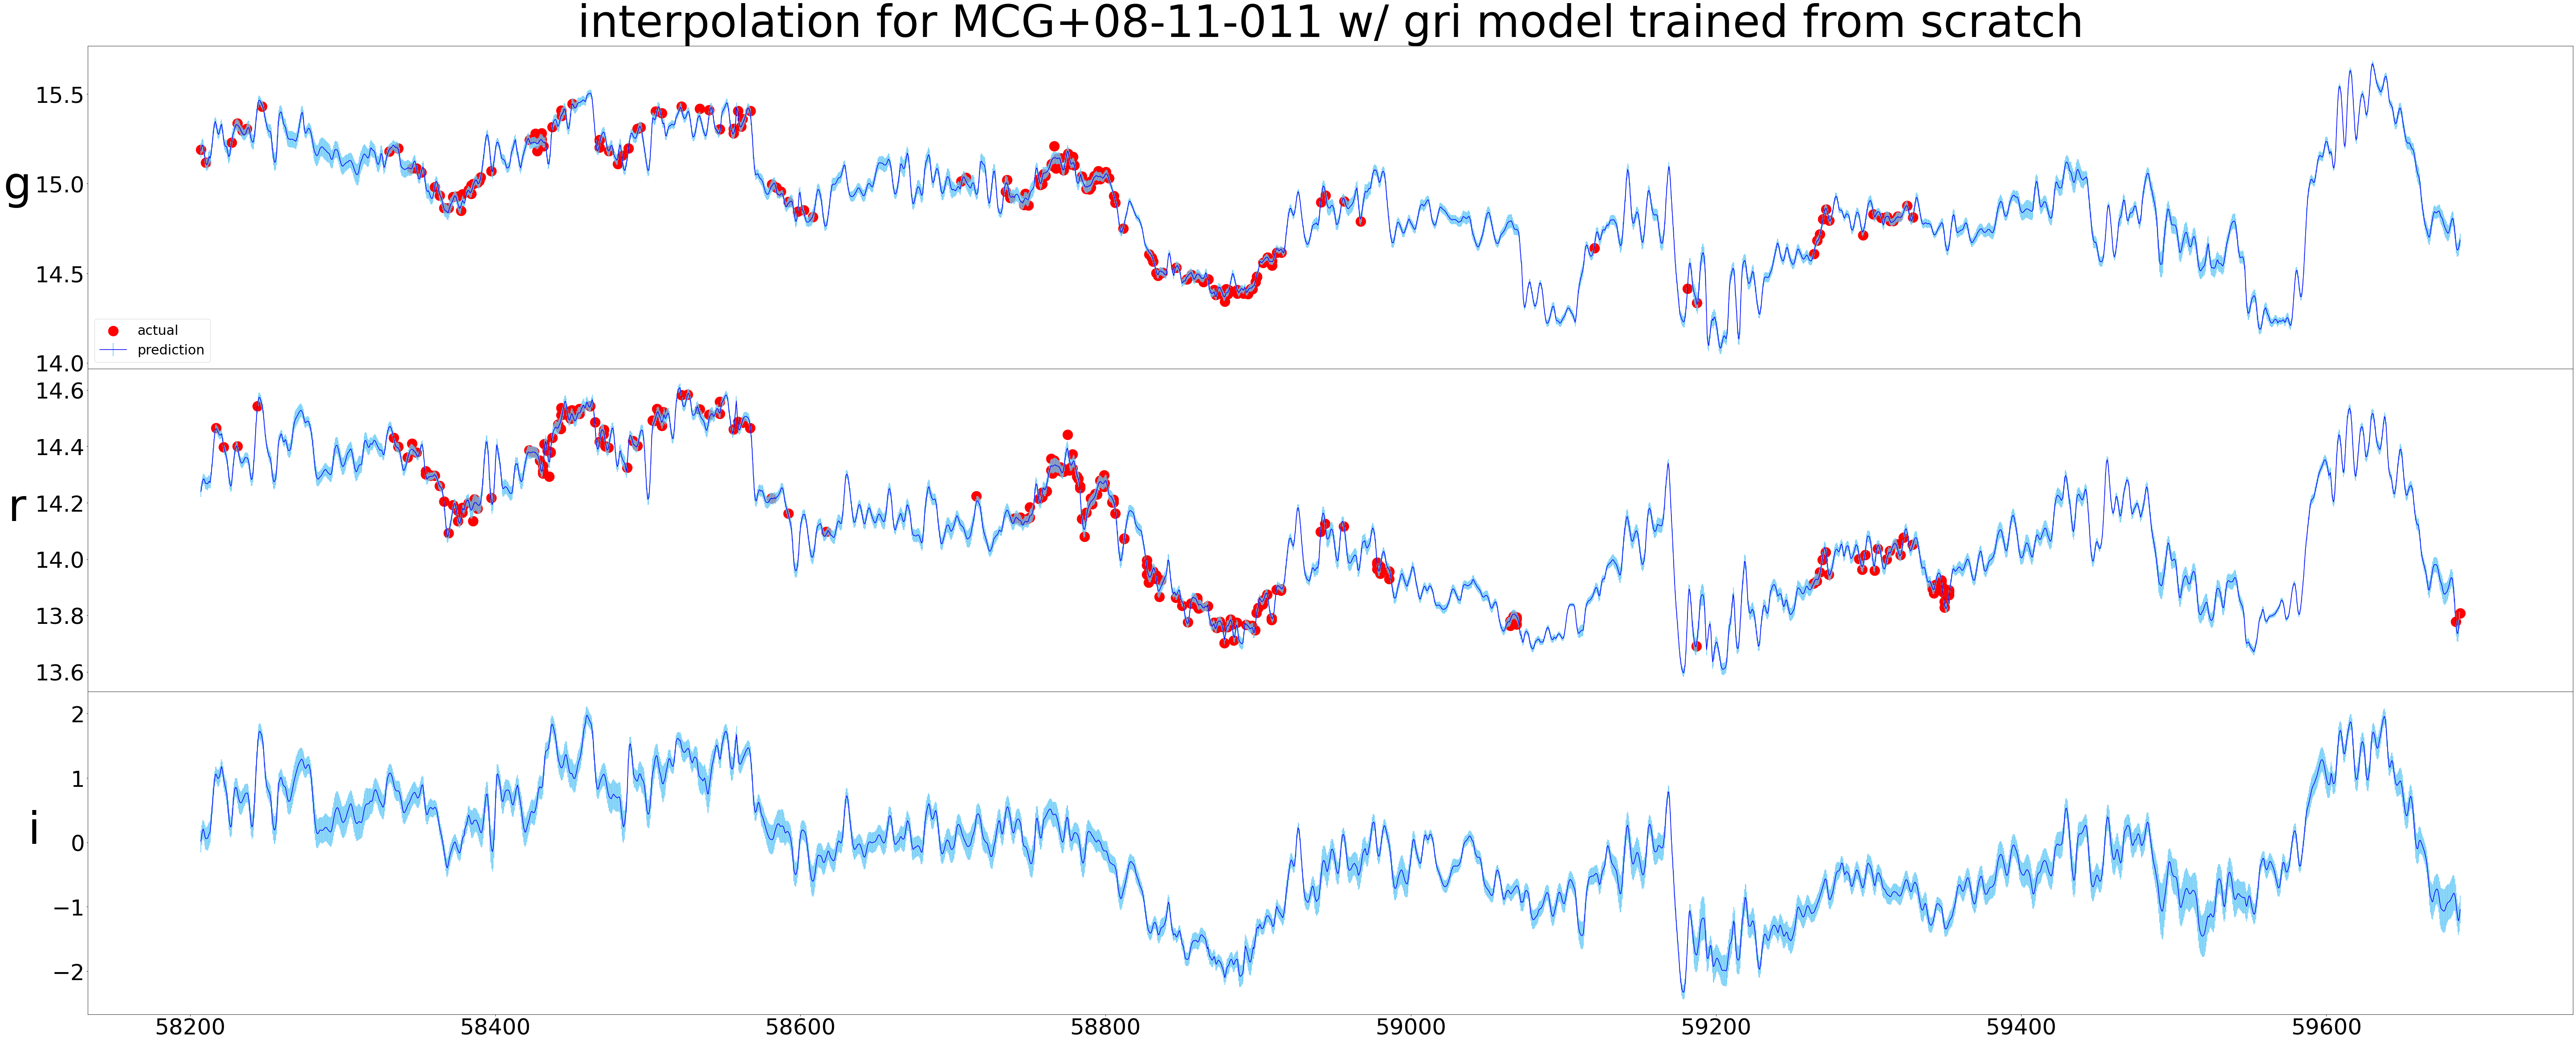

In [46]:
plt.rcParams['xtick.labelsize']=50
plt.rcParams['ytick.labelsize']=50  
dims = len(lcs.bands)
figsize=(100,40)
fig,ax = plt.subplots(dims,figsize=figsize)
for i, band in enumerate([2,0,1]):
    t=intps[0,band,:,0]
    y=intps[:,band,:,1].mean(0)
    yerr=intps[:,band,:,2].mean(0)
    if lcs.bands[band] == 'i':
        t = t+58207.16796875
    np.savetxt(f'../intrps/MCG+08-11-011/gri_scratch/MCG+08-11-011_{lcs.bands[band]}', np.stack((t,y,yerr)).T)
#     ax[i].fill_between(t,y-yerr,y+yerr, label='error envelope',color='lightcoral')
    ax[i].errorbar(t,y,yerr=yerr, c='blue', ecolor='#65c9f7', label='prediction')
    ax[i].set_ylabel(lcs.bands[band],fontsize=100,rotation=0,labelpad=40)
    #ax[band].scatter(t,y)
    if lcs.unnormalized_data[0][band][:,1].any(): # not missing light curves
        ax[i].scatter(lcs.unnormalized_data[0][band][:,0], lcs.unnormalized_data[0][band][:,1],marker='o',color='r',s=500,label='actual')
ax[0].legend(loc='lower left',fontsize=30)
ax[0].set_title('interpolation for MCG+08-11-011 w/ gri model trained from scratch',fontsize=100)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('../img/intrps/MCG+08-11-011_gri_scratch')


In [ ]:
### save to be ROA ready, or ZDCF ready

In [74]:
save_folder = 'gri_interps'

if not os.path.isdir(save_folder): os.mkdir(save_folder)

obj_names = lcs.valid_files_df.index


for i in range(len(interps)):
    for j,band in enumerate(lcs.bands):
        np.savetxt(os.path.join(save_folder,f'{obj_names[i]}_{band}'), interps[i,j])